In [12]:
import numpy as np
import matplotlib.pyplot as plt

In [20]:
# https://github.com/inoryy/csb-ai-starter

In [3]:
class Collision:
    def __init__(self,a,b,t):
        self.a = a
        self.b = b
        self.t = t

class Point:
    
    def __init__(self,x,y):
        self.x = x
        self.y = y

    def dist(self,p):
        return np.sqrt(pow((self.x - p.x), 2) + pow((self.y - p.y), 2))
    
    def dist2(self,p):
        return pow((self.x - p.x), 2) + pow((self.y - p.y), 2)

    def closest(self,a,b):
        da = b.y - a.y
        db = a.x - b.x
        c1 = da*a.x + db*a.y
        c2 = -db*self.x + da*self.y
        det = da*da + db*db

        if det != 0:
            cx = (da*c1 - db*c2) / det
            cy = (da*c2 + db*c1) / det
        else:
            cx = self.x
            cy = self.y

        return Point(cx, cy)
        
class Unit(Point):
    
    def __init__(self,x,y):
        Point.__init__(self,x,y)
        self.cache = np.zeros(4)
        self.vx = 0
        self.vy = 0
        
    def bounce(self,u):
        pass

    def collision_time(self,u):
        if self.vx == u.vx and self.vy == u.vy:
            return -1

        sr2 = 357604 if u.type == 1 else 640000

        dx = self.x - u.x
        dy = self.y - u.y
        dvx = self.vx - u.vx
        dvy = self.vy - u.vy
        a = dvx*dvx + dvy*dvy

        if a < 0.00001:
            return -1

        b = -2.0*(dx*dvx + dy*dvy)
        delta = b*b - 4.0*a*(dx*dx + dy*dy - sr2)

        if delta < 0.0:
            return -1

        t = (b - np.sqrt(delta))*(1.0/(2.0*a))

        if t <= 0.0 or t > 1.0:
            return -1

        return t

    def save(self):
        self.cache[0] = self.x
        self.cache[1] = self.y
        self.cache[2] = self.vx
        self.cache[3] = self.vy

    def load(self):
        self.x = self.cache[0]
        self.y = self.cache[1]
        self.vx = self.cache[2]
        self.vy = self.cache[3]

class Checkpoint(Unit):
    
    def __init__(self,id_, x, y):
        Unit.__init__(self,x,y)
        self.id = id_

        self.vx = self.vy = 0
        self.type = 1
        self.r = 600
        
    def bounce(u):
        pass

class Pod(Unit):
    
    def __init__(self,id_,cps,laps):
        Unit.__init__(self,0,0)
        self.id = id_
        self.r = 400
        self.type = 0
        self.ncpid = 1
        
        self.timeout = 100
        self.has_boost = True
        self.checked = 0
        self.shield = 0
        self.angle = -1
        self.next_angle = -1
        self.cache = np.zeros(6)
        self.partner = None
        self.laps = laps
        self.cp_ct = len(cps)
        self.cps = cps

    def score(self):
        return self.checked*50000 - self.dist(self.cps[self.ncpid]) + 20000

    def apply(self,thrust, angle):
        angle = max(-18., min(18., angle))
        self.angle += angle
        if self.angle >= 360.:
            self.angle = self.angle - 360.
        elif self.angle < 0.0:
            self.angle += 360.

        if (thrust == -1):
            self.shield = 4
        else:
            self.boost(thrust)

    def rotate(self,p):
        a = self.diff_angle(p)
        a = max(-18., min(18., a))

        self.angle += a
        if self.angle >= 360.:
            self.angle = self.angle - 360.
        elif self.angle < 0.0:
            self.angle += 360.

    def boost(self,thrust):
        if self.shield > 0:
            return

        ra = self.angle * np.pi / 180.0

        self.vx += np.cos(ra) * thrust
        self.vy += np.sin(ra) * thrust
    

    def move(self,t):
        self.x += self.vx * t
        self.y += self.vy * t
    

    def end(self):
        self.x = round(self.x)
        self.y = round(self.y)
        self.vx = int(self.vx * 0.85)
        self.vy = int(self.vy * 0.85)
        if self.checked >= self.cp_ct * self.laps:
            self.ncpid = 0
            self.checked = self.cp_ct * self.laps
        
        self.timeout -= 1
        if self.shield > 0:
            self.shield -= 1
    

    def bounce(self,u):
        if u.type == 1:
            self.checked += 1
            self.timeout = 100
            if self.partner != None:
                self.partner.timeout = 100
            self.ncpid = (self.ncpid + 1) % self.cp_ct
            return
        
        self.bounce_w_pod(u)
    

    def bounce_w_pod(self,u):
        m1 = 10 if self.shield == 4 else 1.
        m2 = 10 if u.shield == 4 else 1.
        mcoeff = (m1 + m2) / (m1 * m2)

        nx = self.x - u.x
        ny = self.y - u.y
        dst2 = nx*nx + ny*ny
        dvx = self.vx - u.vx
        dvy = self.vy - u.vy
        prod = (nx*dvx + ny*dvy) / (dst2 * mcoeff)
        fx = nx * prod
        fy = ny * prod
        m1_inv = 1.0 / m1
        m2_inv = 1.0 / m2

        self.vx -= fx * m1_inv
        self.vy -= fy * m1_inv
        u.vx += fx * m2_inv
        u.vy += fy * m2_inv

        impulse = np.sqrt(fx*fx + fy*fy)
        if impulse < 120.:
            df = 120.0 / impulse
            fx *= df
            fy *= df
        
        self.vx -= fx * m1_inv
        self.vy -= fy * m1_inv
        u.vx += fx * m2_inv
        u.vy += fy * m2_inv
    

    def diff_angle(self,p):
        a = self.get_angle(p)
        right = a - self.angle if self.angle <= a else 360. - self.angle + a
        left = self.angle - a if self.angle >= a else self.angle + 360. - a

        if right < left:
            return right
        
        return -left
    

    def get_angle(self,p):
        d = self.dist(p)
        if d == 0:
            d = 0.00001
        dx = (p.x - self.x) / d
        dy = (p.y - self.y) / d

        a = np.arccos(dx) * 180 / np.pi

        if dy < 0:
            a = 360 - a

        return a
    

    def update(self, x, y, vx, vy, angle, ncpid):
        if self.shield > 0:
            self.shield -= 1
        if ncpid != self.ncpid:
            self.timeout = self.partner.timeout = 100
            self.checked+=1
        else:
            self.timeout-=1
        
        self.x = x
        self.y = y
        self.vx = vx
        self.vy = vy
        self.ncpid = ncpid
        
        is_p2 = False
        if is_p2 and self.id > 1: 
            self.swap(angle, self.next_angle)
        self.angle = angle
        r = -1
        if r == 0:
            self.angle = 1 + self.diff_angle(self.cps[1])
        self.save()
    
    def save(self):
        super().save()
        self.cache[0] = self.ncpid
        self.cache[1] = self.checked
        self.cache[2] = self.timeout
        self.cache[3] = self.shield
        self.cache[4] = self.angle
        self.cache[5] = self.has_boost
    
    def load(self):
        self.load(self)
        self.ncpid   = self.cache[0]
        self.checked = self.cache[1]
        self.timeout = self.cache[2]
        self.shield  = self.cache[3]
        self.angle   = self.cache[4]
        self.has_boost = self.cache[5]
    
    def __str__(self):
        print("Velocity: (" + str(self.vx) + "," + str(self.vy) + ")")

In [4]:
checkpoint_pool = []
ch0 = []
ch0.append(Checkpoint(0, 13939, 1936))
ch0.append(Checkpoint(1, 7996, 3277))
ch0.append(Checkpoint(2, 2642, 7014))
ch0.append(Checkpoint(3, 10025, 5946))
checkpoint_pool.append(ch0)

ch1 = []
ch1.append(Checkpoint(0, 7828, 836))
ch1.append(Checkpoint(1, 7659, 5995))
ch1.append(Checkpoint(2, 3169, 7536))
ch1.append(Checkpoint(3, 9495, 4351))
ch1.append(Checkpoint(4, 14516, 7793))
ch1.append(Checkpoint(5, 6331, 4292))
checkpoint_pool.append(ch1)

ch2 = []
ch2.append(Checkpoint(0, 13868, 1212))
ch2.append(Checkpoint(1, 10243, 4906))
ch2.append(Checkpoint(2, 6075, 2209))
ch2.append(Checkpoint(3, 3035, 5181))
ch2.append(Checkpoint(4, 6274, 7779))
ch2.append(Checkpoint(5, 14112, 7758))
checkpoint_pool.append(ch2)

ch3 = []
ch3.append(Checkpoint(0, 14679, 1407))
ch3.append(Checkpoint(1, 3431, 7235))
ch3.append(Checkpoint(2, 9424, 7225))
ch3.append(Checkpoint(3, 5990, 4252))
checkpoint_pool.append(ch3)

ch4 = []
ch4.append(Checkpoint(0, 13506, 2367))
ch4.append(Checkpoint(1, 12945, 7247))
ch4.append(Checkpoint(2, 5646, 2586))
ch4.append(Checkpoint(3, 4118, 7442))
checkpoint_pool.append(ch4)

ch5 = []
ch5.append(Checkpoint(0, 11495, 6084))
ch5.append(Checkpoint(1, 9127, 1863))
ch5.append(Checkpoint(2, 4984, 5248))
checkpoint_pool.append(ch5)

ch6 = []
ch6.append(Checkpoint(0, 13575, 7620))
ch6.append(Checkpoint(1, 12478, 1332))
ch6.append(Checkpoint(2, 10562, 6005))
ch6.append(Checkpoint(3, 3577, 5201))
checkpoint_pool.append(ch6)

In [5]:
def play(pods):
        t = 0.0
        while t < 1.0:
            first_col = Collision(None,None,-1)
            for i in range(len(pods)):
                for j in range(i+1,len(pods)):
                    col_time = pods[i].collision_time(pods[j])
                    if col_time > -1 and col_time + t < 1.0 and (first_col.t == -1 or col_time < first_col.t):
                        first_col.a = pods[i]
                        first_col.b = pods[j]
                        first_col.t = col_time
                    
                # TODO this is wasteful, get rid of it
                col_time = pods[i].collision_time(cps[pods[i].ncpid])
                if col_time > -1 and col_time + t < 1.0 and (first_col.t == -1 or col_time < first_col.t):
                    first_col.a = pods[i]
                    first_col.b = cps[pods[i].ncpid]
                    first_col.t = col_time
                
            if first_col.t == -1:
                for i in range(len(pods)):
                    pods[i].move(1.0 - t)
                
                t = 1.0
            else:
                for i in range(len(pods)):
                    pods[i].move(first_col.t)
                
                first_col.a.bounce(first_col.b)
                t += first_col.t
            
        for i in range(len(pods)):
            pods[i].end()

In [6]:
# pick a Level
cps = checkpoint_pool[np.random.randint(len(ch6))]

laps = 2

In [23]:
# init pods
def init_pods():
    pods = []
    for i in range(2):
        p = Pod(i,cps,laps)
        p.x = np.random.randint(500)
        p.y = np.random.randint(500)
        p.vx = 0
        p.vy = 0
        p.angle = 0
        pods.append(p)
    return pods

In [24]:
pods = init_pods()

loop = True
while loop:
    for i,pod in enumerate(pods):
        cp = cps[pod.ncpid]
        cp_p = Point(cp.x, cp.y)
        
        dist_next_cp = pod.dist(cp_p)
        raw_angle_next_cp = pod.diff_angle(cp_p)
        
        angle = max(-18, min(18, raw_angle_next_cp))

        pod.apply(100, angle)
        
        play(pods)
        
    for pod in pods:
        if pod.checked == int(len(cps)*laps) or pod.timeout < 0:
            loop = False

233.0
79.0


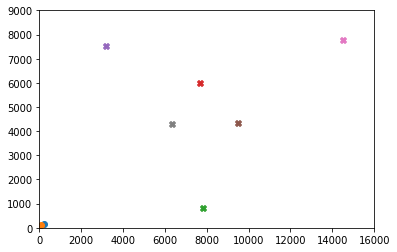

363.0
213.0


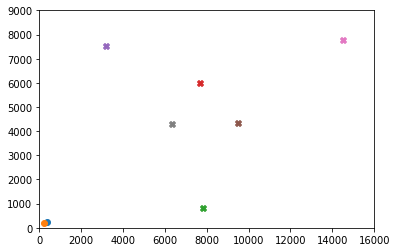

558.0
417.0


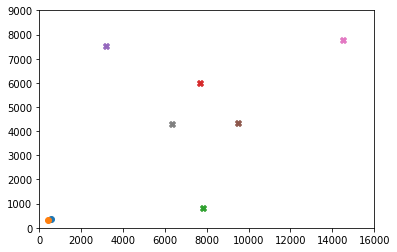

779.0
665.0


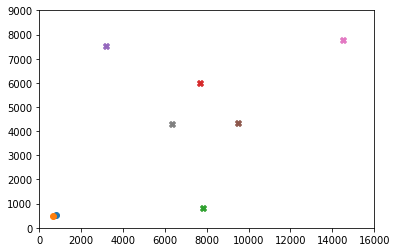

993.0
948.0


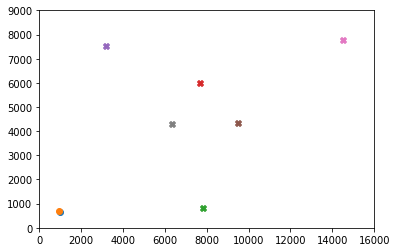

1197.0
1222.0


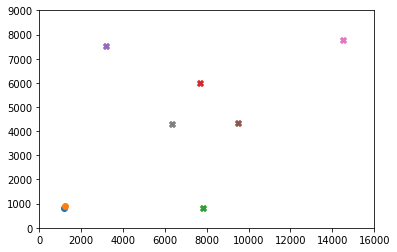

1410.0
1497.0


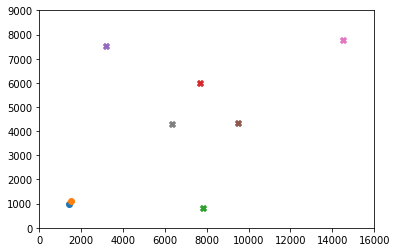

1604.0
1817.0


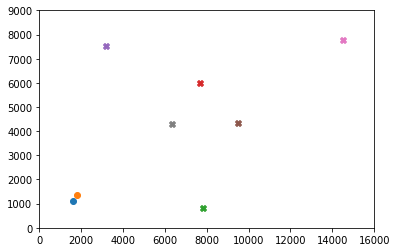

1783.0
2144.0


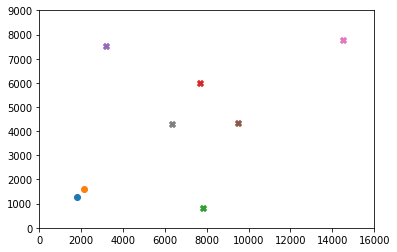

1973.0
2480.0


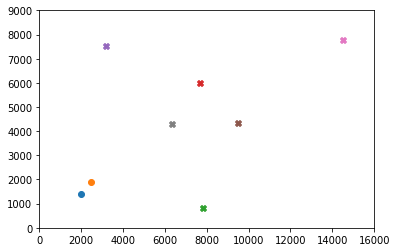

2149.0
2851.0


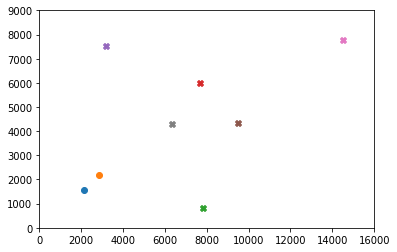

2361.0
3250.0


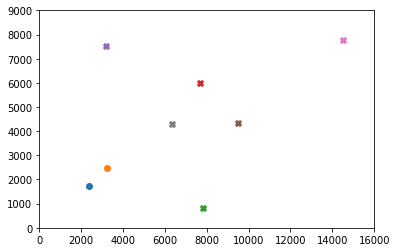

2579.0
3645.0


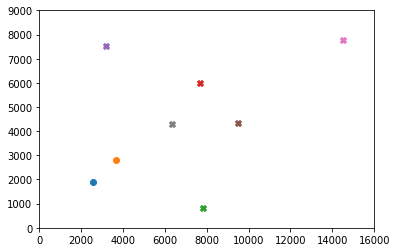

2810.0
4029.0


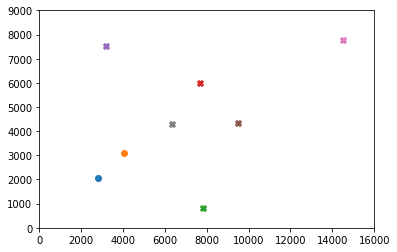

3094.0
4406.0


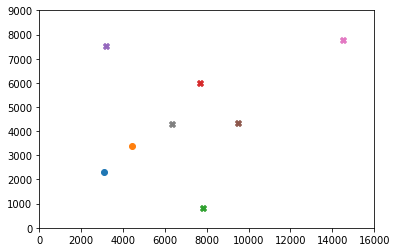

3378.0
4767.0


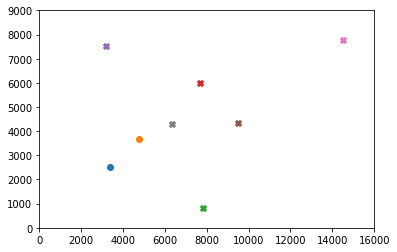

3662.0
5103.0


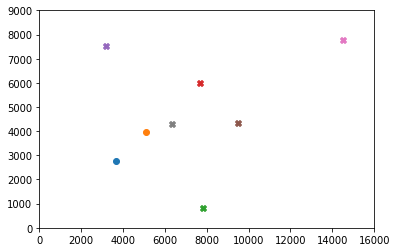

3913.0
5432.0


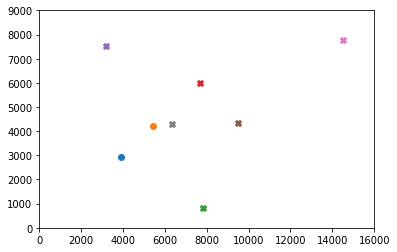

4126.0
5771.0


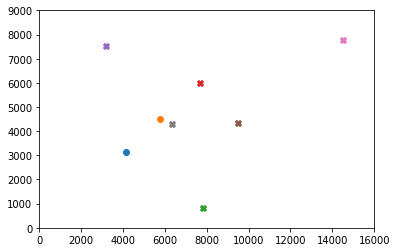

4361.0
6073.0


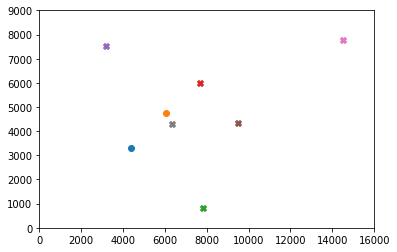

4595.0
6313.0


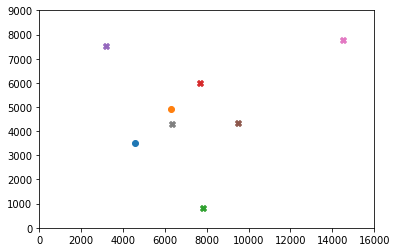

4845.0
6550.0


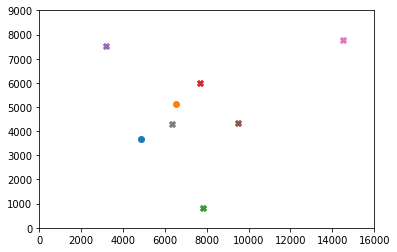

5088.0
6772.0


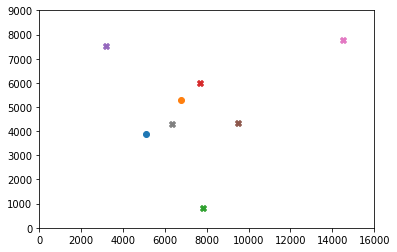

5304.0
6967.0


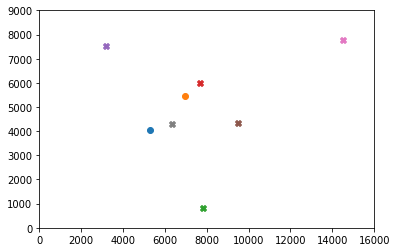

5546.0
7134.0


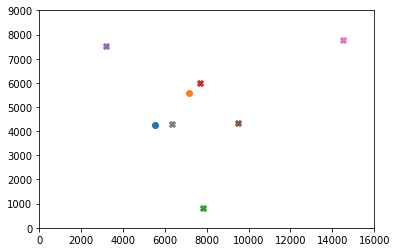

5829.0
7302.0


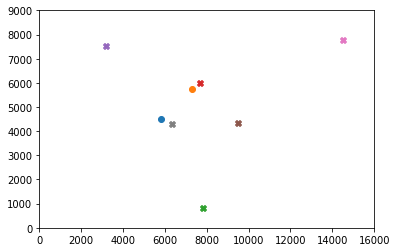

6117.0
7470.0


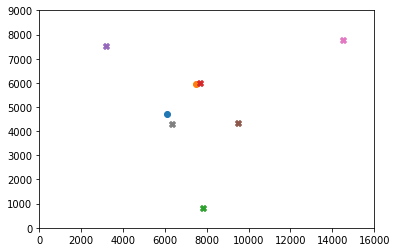

6395.0
7592.0


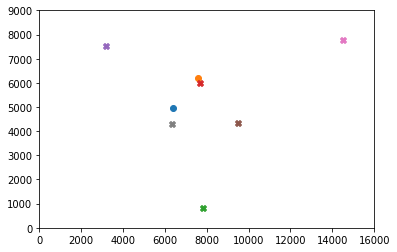

6698.0
7647.0


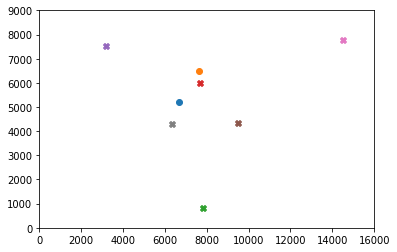

7002.0
7640.0


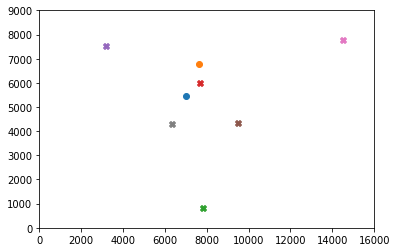

7299.0
7559.0


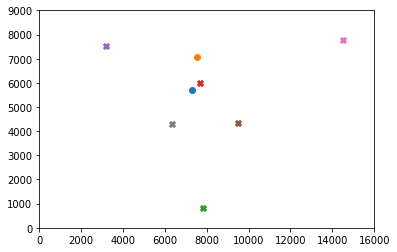

7596.0
7447.0


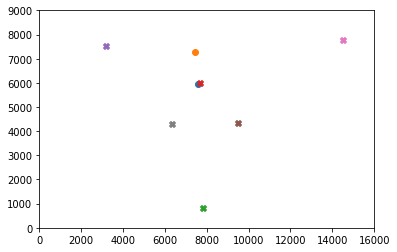

7848.0
7329.0


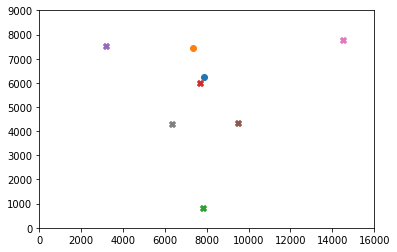

8032.0
7197.0


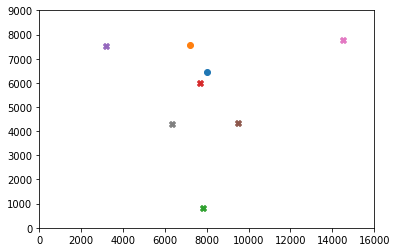

8142.0
7068.0


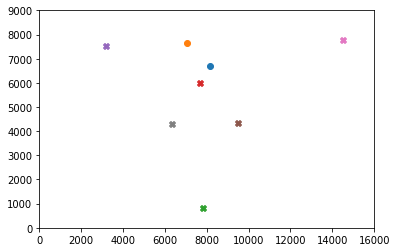

8179.0
6927.0


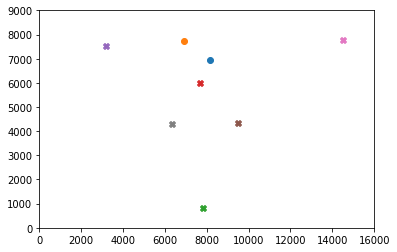

8112.0
6773.0


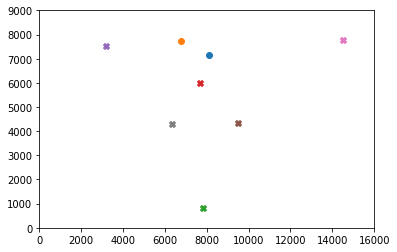

7911.0
6585.0


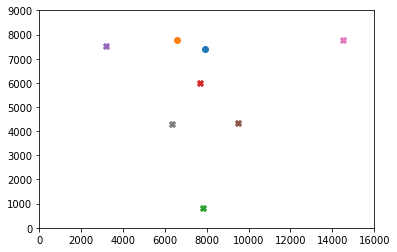

7642.0
6392.0


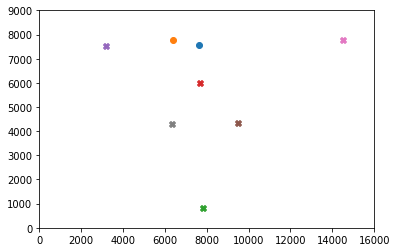

7324.0
6240.0


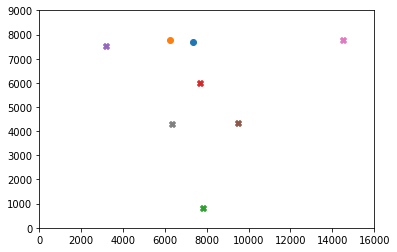

6990.0
5819.0


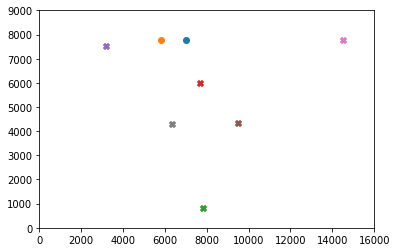

6888.0
5344.0


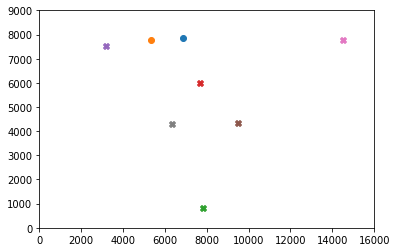

6731.0
4954.0


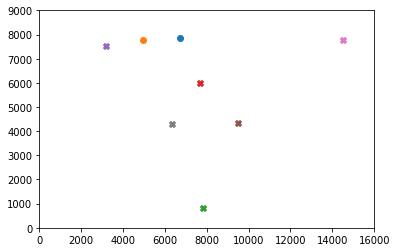

6490.0
4558.0


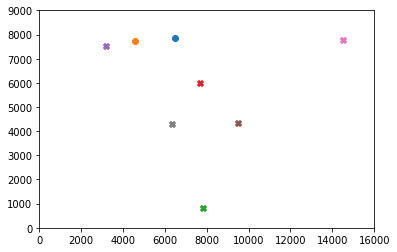

6216.0
4126.0


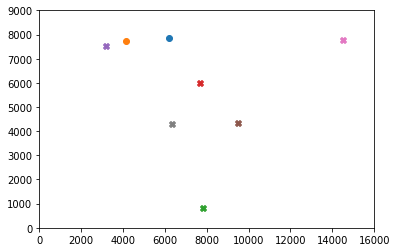

5907.0
3707.0


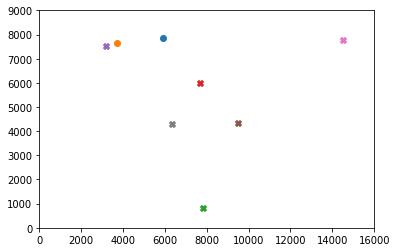

5588.0
3321.0


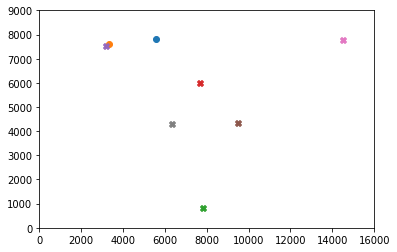

5272.0
2951.0


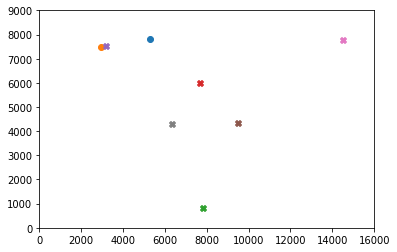

KeyboardInterrupt: 

In [25]:
pods = init_pods()

loop = True
plt.figure()
while loop:
    plt.clf()
    plt.xlim(0, 16000)
    plt.ylim(0, 9000)
    for i,pod in enumerate(pods):
        cp = cps[pod.ncpid]
        cp_p = Point(cp.x, cp.y)
        
        dist_next_cp = pod.dist(cp_p)
        raw_angle_next_cp = pod.diff_angle(cp_p)
        
        angle = max(-18, min(18, raw_angle_next_cp))

        pod.apply(100*np.random.rand(1)[0], angle)
        
        play(pods)
        
        plt.scatter(pod.x,pod.y)
    
    for c in cps:
        plt.scatter(c.x,c.y, marker="X")

    plt.pause(0.3)
    plt.draw()

    for pod in pods:
        if pod.checked == int(len(cps)*laps) or pod.timeout < 0:
            break